In [49]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Jun  4 19:43:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    32W / 250W |   2595MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import random

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Load data

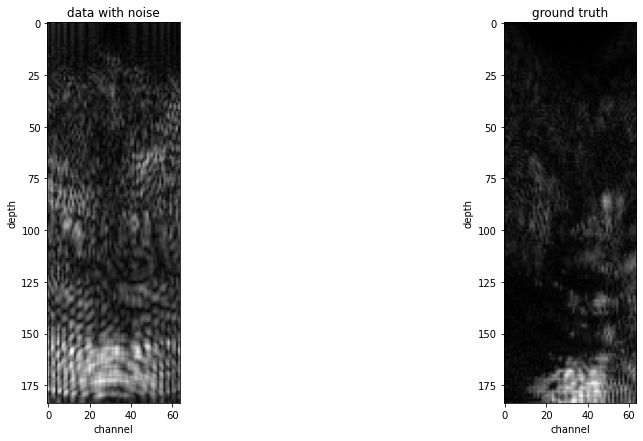

In [52]:
#### Load dataset ####
dataPath ='/content/drive/Shared drives/ECE228/final/dataset/ae/'
inputSet  = np.load(dataPath + 'inputSet1.npy')
labelSet = np.load(dataPath + 'labelSet1.npy')

#### Check US image ####
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.imshow(inputSet[0,:,:], 'gray')
plt.title('data with noise')
plt.xlabel('channel')
plt.ylabel('depth')
plt.subplot(1,2,2)
plt.imshow(labelSet[0,:,:], 'gray')
plt.title('ground truth')
plt.xlabel('channel')
plt.ylabel('depth')
plt.show()

Build Unet

In [45]:

def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'random_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'random_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x
  
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

#input_img = Input((imgSizeY, imgSizeX, 1), name='img')
input_img = Input((176, 64, 1), name='img')
unet = get_unet(input_img)
unet.compile(loss='mse', optimizer='adam')
print(unet.summary())

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 176, 64, 1)   0                                            
__________________________________________________________________________________________________
conv2d_173 (Conv2D)             (None, 176, 64, 16)  160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_164 (BatchN (None, 176, 64, 16)  64          conv2d_173[0][0]                 
__________________________________________________________________________________________________
activation_164 (Activation)     (None, 176, 64, 16)  0           batch_normalization_164[0][0]    
___________________________________________________________________________________________

wash data

(71, 176, 64, 1)
(1000, 176, 64, 1)
(100, 176, 64, 1)


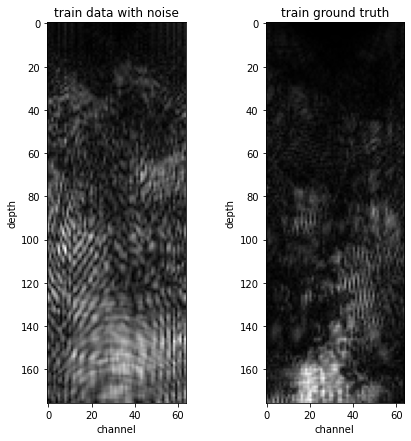

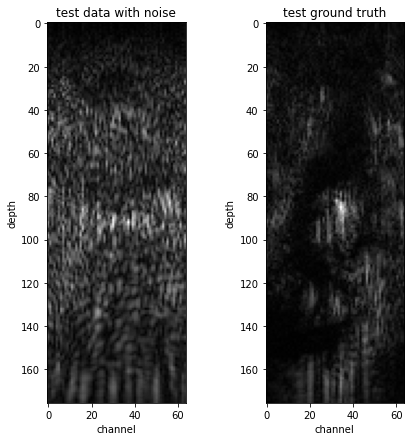

In [67]:
# data reshape (data the has already been normalized)
inputSet_reshape = inputSet.reshape(inputSet.shape[0],inputSet.shape[1],inputSet.shape[2],1)
labelSet_reshape = labelSet.reshape(labelSet.shape[0],labelSet.shape[1],labelSet.shape[2],1)

# wash data
ranDataIndex = [i for i in range(len(inputSet_reshape))] 
random.Random(1).shuffle(ranDataIndex)
inputSet_reshape_ran = inputSet_reshape[ranDataIndex]
labelSet_reshape_ran = labelSet_reshape[ranDataIndex]

x_test = inputSet_reshape_ran[:2,4:-4,:,:]
y_test = labelSet_reshape_ran[:2,4:-4,:,:]

x_train = inputSet_reshape_ran[2:,4:-4,:,:]
y_train = labelSet_reshape_ran[2:,4:-4,:,:]
print(x_train.shape)

x_train_l = np.zeros([1000,inputSet.shape[1]-8,inputSet.shape[2],1])
y_train_l = np.zeros([1000,inputSet.shape[1]-8,inputSet.shape[2],1])
x_test_l = np.zeros([1000,inputSet.shape[1]-8,inputSet.shape[2],1])
y_test_l = np.zeros([1000,inputSet.shape[1]-8,inputSet.shape[2],1])
for i in range(1000):
  ranLindex = random.randint(0,inputSet.shape[0]-3)
  x_train_temp = x_train[ranLindex,:,:,:]
  y_train_temp = y_train[ranLindex,:,:,:]
  x_train_l[i,:,:,:] = x_train_temp
  y_train_l[i,:,:,:] = y_train_temp

  ranLindexTest = i%2
  x_test_temp = x_test[ranLindexTest,:,:,:]
  y_test_temp = y_test[ranLindexTest,:,:,:]
  x_test_l[i,:,:,:] = x_test_temp
  y_test_l[i,:,:,:] = y_test_temp

np.save("x_train.npy", x_train_l)
np.save("y_train.npy", y_train_l)
np.save("x_test.npy", x_test_l[:100,:,:])
np.save("y_test.npy", y_test_l[:100,:,:])

#### Load dataset ####
x_train  = np.load('x_train.npy')
y_train = np.load('y_train.npy')
x_test  = np.load('x_test.npy')
y_test = np.load('y_test.npy')
print(x_train.shape)
print(y_test.shape)

#### Check US image ####
plt.figure(figsize=(15,7))
plt.subplot(1,4,1)
plt.imshow(x_train[0,:,:,0], 'gray')
plt.title('train data with noise')
plt.xlabel('channel')
plt.ylabel('depth')
plt.subplot(1,4,2)
plt.imshow(y_train[0,:,:,0], 'gray')
plt.title('train ground truth')
plt.xlabel('channel')
plt.ylabel('depth')
plt.figure(figsize=(15,7))
plt.subplot(1,4,3)
plt.imshow(x_test[0,:,:,0], 'gray')
plt.title('test data with noise')
plt.xlabel('channel')
plt.ylabel('depth')
plt.subplot(1,4,4)
plt.imshow(y_test[0,:,:,0], 'gray')
plt.title('test ground truth')
plt.xlabel('channel')
plt.ylabel('depth')
plt.show()

Train the model

Train on 63 samples, validate on 8 samples
Epoch 1/500
63/63 [==============================] - 3s 44ms/step - loss: 0.2470 - val_loss: 0.1694

Epoch 00001: val_loss improved from inf to 0.16943, saving model to model-unet.h5
Epoch 2/500
63/63 [==============================] - 0s 2ms/step - loss: 0.1708 - val_loss: 0.1646

Epoch 00002: val_loss improved from 0.16943 to 0.16458, saving model to model-unet.h5
Epoch 3/500
63/63 [==============================] - 0s 2ms/step - loss: 0.1292 - val_loss: 0.2288

Epoch 00003: val_loss did not improve from 0.16458
Epoch 4/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0997 - val_loss: 0.2770

Epoch 00004: val_loss did not improve from 0.16458
Epoch 5/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0854 - val_loss: 0.4119

Epoch 00005: val_loss did not improve from 0.16458
Epoch 6/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0743 - val_loss: 0.5304

Epoch 00006: val_loss did not impro

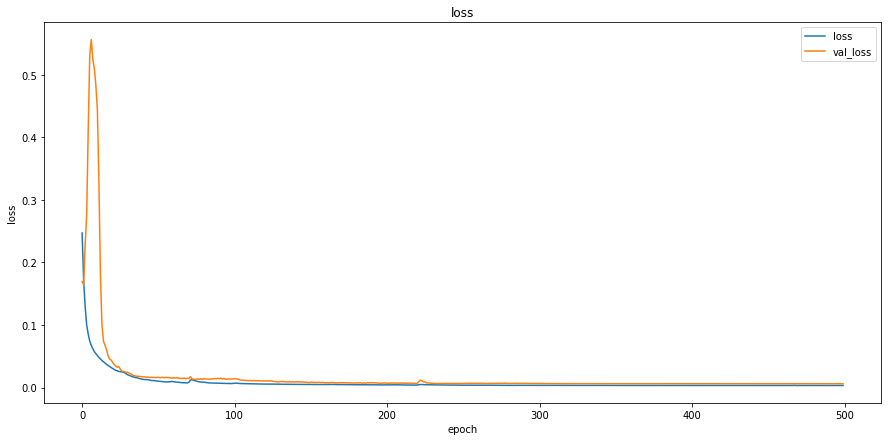

In [47]:
# callback for dynamic learning rate
callbacks = [
    EarlyStopping(patience=60, verbose=1),
    ReduceLROnPlateau(factor=0.0001, patience=50, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-unet.h5', verbose=1, save_best_only=True, save_weights_only=True)
]
history_conv_unet = unet.fit(x_train, y_train, callbacks=callbacks, validation_split=0.1, epochs=500, batch_size=15, shuffle=True)
#history_conv_unet = unet.fit(x_train, y_train, validation_split=0.2, epochs=300, batch_size=25, shuffle=True)

# Plot loss versus epoch.
plt.figure(figsize=(15,7))
plt.plot(history_conv_unet.history['loss'],label='loss')
plt.plot(history_conv_unet.history['val_loss'],label='val_loss')
plt.legend(loc='upper right')
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

Test Model

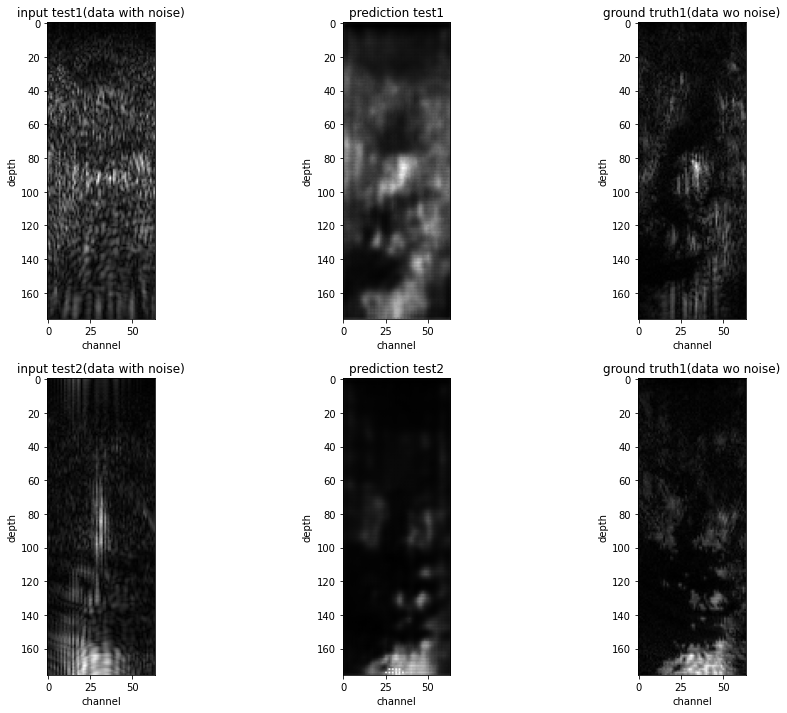

In [48]:
y_pred = unet.predict(x_test)

plt.figure(figsize=(15,12))
plt.subplot(2,3,1)
plt.imshow(x_test[0,:,:,0], 'gray')
plt.title('input test1(data with noise)')
plt.xlabel('channel')
plt.ylabel('depth')
plt.subplot(2,3,2)
plt.imshow(y_pred[0,:,:,0], 'gray')
plt.title('prediction test1')
plt.xlabel('channel')
plt.ylabel('depth')
plt.subplot(2,3,3)
plt.imshow(y_test[0,:,:,0], 'gray')
plt.title('ground truth1(data wo noise)')
plt.xlabel('channel')
plt.ylabel('depth')
plt.subplot(2,3,4)
plt.imshow(x_test[1,:,:,0], 'gray')
plt.title('input test2(data with noise)')
plt.xlabel('channel')
plt.ylabel('depth')
plt.subplot(2,3,5)
plt.imshow(y_pred[1,:,:,0], 'gray')
plt.title('prediction test2')
plt.xlabel('channel')
plt.ylabel('depth')
plt.subplot(2,3,6)
plt.imshow(y_test[1,:,:,0], 'gray')
plt.title('ground truth1(data wo noise)')
plt.xlabel('channel')
plt.ylabel('depth')
plt.show()